In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from alg_functions import *

In [2]:
%pip install astroML


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Obtain the Data

In [3]:
from astroML.datasets import fetch_rrlyrae_combined

X, y = fetch_rrlyrae_combined()

X = X[-5000:]
y = y[-5000:]

stars = (y == 0)
rrlyrae = (y == 1)

# Create a DataFrame from the array X
df = pd.DataFrame(X[:,0:2], columns=['u-g', 'g-r'])

# Add the array y as a new column to the DataFrame
df['type'] = np.where(y==0, 'stars', 'RR-Lyrae')

pred_columns_lyrae = ['u-g', 'g-r']

display(df.head())

,u-g,g-r,type
0,1.028999,0.379000,stars
1,0.945000,0.305000,stars
2,1.118000,0.396000,stars
3,0.962000,0.375000,stars
4,1.052000,0.335001,stars


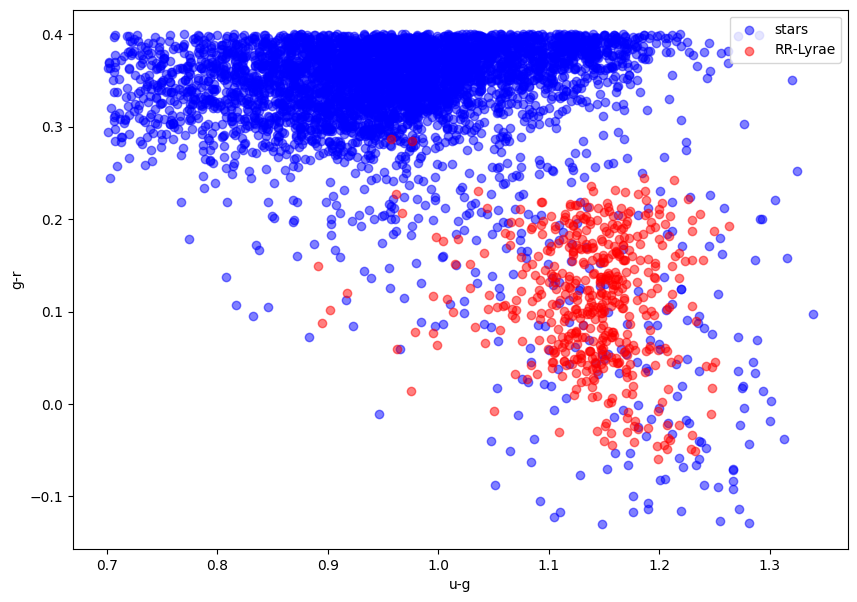

In [4]:
stars_df = df[df['type'] == 'stars']
rrlyrae_df = df[df['type'] == 'RR-Lyrae']

pred_columns_lyrae = ['u-g', 'g-r']

plt.figure(figsize=(10, 7))

plt.scatter(stars_df['u-g'], stars_df['g-r'], c='b', label='stars', alpha=0.5)
plt.scatter(rrlyrae_df['u-g'], rrlyrae_df['g-r'], c='r', label='RR-Lyrae', alpha=0.5)

plt.legend(loc='upper right')

plt.xlabel('u-g')
plt.ylabel('g-r')

plt.show()

# Algorithm 1

In [36]:
for epsilon in [0.01, 0.001, 0.0001]:

    pred_columns_lyrae = ['u-g', 'g-r']

    # Create a train and test set
    train_set = df[df['type'] == 'RR-Lyrae'][pred_columns_lyrae].iloc[:len(df[df['type'] == 'RR-Lyrae'])//2]
    test_set = pd.concat([df[df['type'] == 'stars'],df[df['type'] == 'RR-Lyrae'].iloc[len(df[df['type'] == 'RR-Lyrae'])//2:]], ignore_index=True)
    
    # Remove outliers from the train set
    # outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns_lyrae])) > 3).all(axis=1)]
    # train_set = train_set[~train_set.isin(outliers)].dropna()

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Away Step Frank-Wolfe algorithm
    c, r, k, chi, timer = frank_wolfe_alg_MEB(epsilon, train_set.values)

    # Calculate Accuracies
    distances = np.linalg.norm(test_set[pred_columns_lyrae] - c, axis=1)
    test_set['InsideBall'] = distances < r
    print(measure_accuracy('stars', 'RR-Lyrae', test_set))

---------------
Epsilon:  0.01
Center: [1.0857737  0.11452863]
Radius: 0.21738365545987998
Iterations: 67
CPU time: 0.05292391777038574
Core Set Size: 4
                Metric        Count
0   True Positive (TP)   241.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)  4079.000000
3  False Positive (FP)   438.000000
4            Precision     0.354934
5               Recall     0.995868
6             F1 Score     0.523344
---------------
Epsilon:  0.001
Center: [1.09202959 0.11835356]
Radius: 0.216259984253153
Iterations: 875
CPU time: 0.5836241245269775
Core Set Size: 4
                Metric        Count
0   True Positive (TP)   241.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)  4063.000000
3  False Positive (FP)   454.000000
4            Precision     0.346763
5               Recall     0.995868
6             F1 Score     0.514408
---------------
Epsilon:  0.0001
Center: [1.09225704 0.11827635]
Radius: 0.21624679589343906
Iterations: 1000
CPU time:

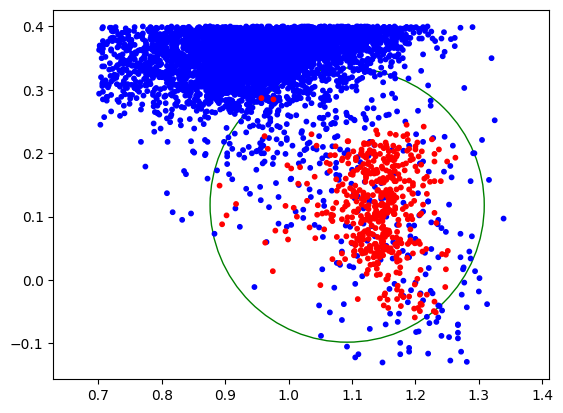

In [37]:
circle = plt.Circle(tuple(c), r, color='g', fill=False)

ax = plt.gca()
ax.cla()
ax.add_patch(circle)
plt.axis('equal')
plt.scatter(df['u-g'], df['g-r'], c=np.where(df['type'] == 'RR-Lyrae', 'r', 'b'), s=10)

# Algorithm 2

In [38]:
for epsilon in [0.01, 0.001, 0.0001]:

    pred_columns_lyrae = ['u-g', 'g-r']

    # Create a train and test set
    train_set = df[df['type'] == 'RR-Lyrae'][pred_columns_lyrae].iloc[:len(df[df['type'] == 'RR-Lyrae'])//2]
    test_set = pd.concat([df[df['type'] == 'stars'],df[df['type'] == 'RR-Lyrae'].iloc[len(df[df['type'] == 'RR-Lyrae'])//2:]], ignore_index=True)
    
    # Remove outliers from the train set
    # outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns_lyrae])) > 0.5).all(axis=1)]
    # train_set = train_set[~train_set.isin(outliers)].dropna()

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Away Step Frank-Wolfe algorithm
    center_as, radius_as, count_iterations_as, CPU_time_as, dual_val_list_as, dual_gap_list_as = frankWolfe_AwayStep(train_set.values, epsilon)

    # Calculate Accuracies
    distances = np.linalg.norm(test_set[pred_columns_lyrae] - center_as, axis=1)
    test_set['InsideBall'] = distances < radius_as
    print(measure_accuracy('stars', 'RR-Lyrae', test_set))

---------------
Epsilon:  0.01
Center: [1.06274187 0.10480568]
Radius: 0.21065772207896935
Iterations: 6
CPU time: 0.010406017303466797
Set Size: 3
                Metric        Count
0   True Positive (TP)   237.000000
1  False Negative (FN)     5.000000
2   True Negative (TN)  4149.000000
3  False Positive (FP)   368.000000
4            Precision     0.391736
5               Recall     0.979339
6             F1 Score     0.559622
---------------
Epsilon:  0.001
Center: [1.09299946 0.11899996]
Radius: 0.21614912712314582
Iterations: 8
CPU time: 0.008002996444702148
Set Size: 2
                Metric        Count
0   True Positive (TP)   241.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)  4061.000000
3  False Positive (FP)   456.000000
4            Precision     0.345768
5               Recall     0.995868
6             F1 Score     0.513312
---------------
Epsilon:  0.0001
Center: [1.09299946 0.11899996]
Radius: 0.21614912712314582
Iterations: 8
CPU time: 0.02979183

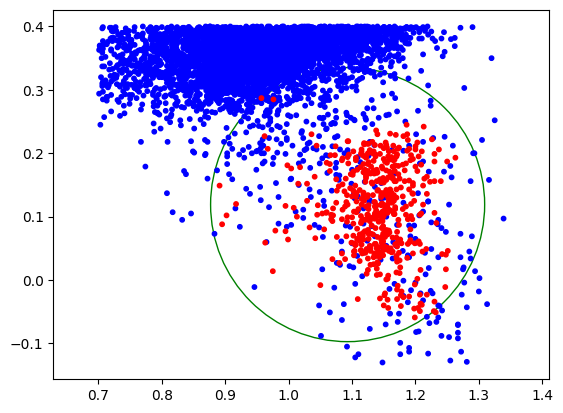

In [39]:
circle = plt.Circle(tuple(center_as), radius_as, color='g', fill=False)

ax = plt.gca()
ax.cla()
ax.add_patch(circle)
plt.axis('equal')
plt.scatter(df['u-g'], df['g-r'], c=np.where(df['type'] == 'RR-Lyrae', 'r', 'b'), s=10)

# Algorithm 3

In [40]:
for epsilon in [0.01, 0.001, 0.0001]:

    pred_columns_lyrae = ['u-g', 'g-r']

    # Create a train and test set
    train_set = df[df['type'] == 'RR-Lyrae'][pred_columns_lyrae].iloc[:len(df[df['type'] == 'RR-Lyrae'])//2]
    test_set = pd.concat([df[df['type'] == 'stars'],df[df['type'] == 'RR-Lyrae'].iloc[len(df[df['type'] == 'RR-Lyrae'])//2:]], ignore_index=True)
    
    # Remove outliers from the train set
    # outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns_lyrae])) > 0.5).all(axis=1)]
    # train_set = train_set[~train_set.isin(outliers)].dropna()

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Pairwise Frank-Wolfe algorithm
    center_pw, radius_pw, count_iterations_pw, CPU_time_pw, dual_val_list_pw, dual_gap_list_pw = frankWolfe_Pairwise(train_set.values, epsilon)

    # Calculate Accuracies
    distances = np.linalg.norm(test_set[pred_columns_lyrae] - center_pw, axis=1)
    test_set['InsideBall'] = distances < radius_pw
    print(measure_accuracy('stars', 'RR-Lyrae', test_set))

---------------
Epsilon:  0.01
Center: [1.0926367  0.11783558]
Radius: 0.21605686483014264
Iterations: 4
CPU time: 0.021091938018798828
Set Size: 3
                Metric        Count
0   True Positive (TP)   241.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)  4079.000000
3  False Positive (FP)   438.000000
4            Precision     0.354934
5               Recall     0.995868
6             F1 Score     0.523344
---------------
Epsilon:  0.001
Center: [1.09299946 0.11899996]
Radius: 0.2161491271231448
Iterations: 5
CPU time: 0.010562896728515625
Set Size: 2
                Metric        Count
0   True Positive (TP)   241.000000
1  False Negative (FN)     1.000000
2   True Negative (TN)  4061.000000
3  False Positive (FP)   456.000000
4            Precision     0.345768
5               Recall     0.995868
6             F1 Score     0.513312
---------------
Epsilon:  0.0001
Center: [1.09299946 0.11899996]
Radius: 0.2161491271231448
Iterations: 5
CPU time: 0.0122590065

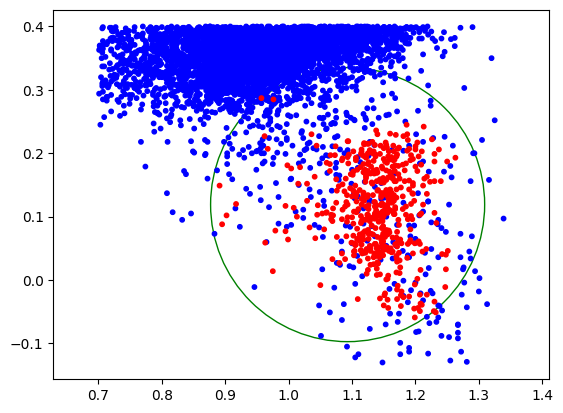

In [41]:
circle = plt.Circle(tuple(center_pw), radius_pw, color='g', fill=False)

ax = plt.gca()
ax.cla()
ax.add_patch(circle)
plt.axis('equal')
plt.scatter(df['u-g'], df['g-r'], c=np.where(df['type'] == 'RR-Lyrae', 'r', 'b'), s=10)